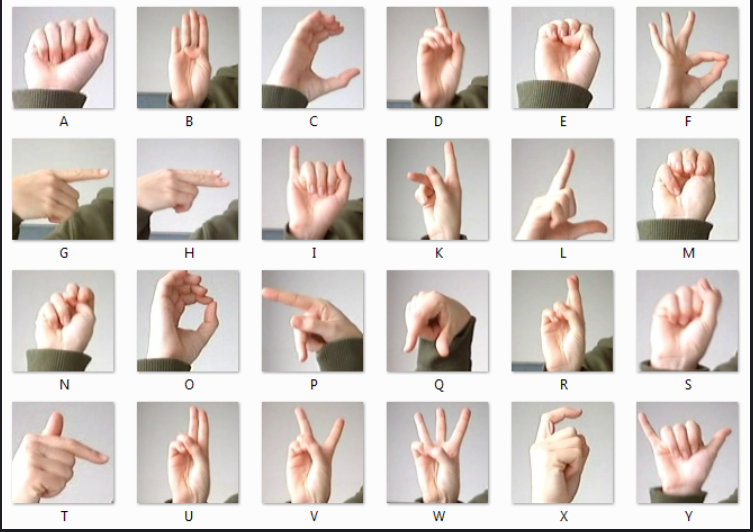

<div style="background-color:#e6f2ff; padding:20px; border-radius:12px; border:1px solid #99ccff;">
  <h2 style="margin:0; color:#003366; text-align:center;">Understanding American Sign Language-using CNN</h2>
  <p style="margin-top:15px; font-size:18px; color:#1a1a1a; line-height:1.6; text-align:center;">
    Description of the Sign-Language MNIST Problem (American Sign Language)¶
American Sign Language (ASL) is a complete, natural language that has the same linguistic properties as spoken languages, with grammar that differs from English. ASL is expressed by movements of the hands and face. It is the primary language of many North Americans who are deaf and hard of hearing, and is used by many hearing people as well. The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity.
  </p>
markdown
</div>


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau


**Using TensorFlow backend**

Loading the ASL datase
 <div style="background-color:white; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Loading the ASL datase </h1>
</div>


In [ ]:
train_df = pd.read_csv("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [ ]:
test = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
y = test['label']

In [ ]:
train_df.head()

 <div style="background-color:yellow; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Data Visualization and Preprocessing </h1>
</div>


In [ ]:
plt.figure(figsize=(10,10))
sns.set_style("darkgrid")
sns.countplot(x='label', data=train_df)
plt.title("Label Count Distribution", fontsize=16)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()


In [ ]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
x_train = train_df.values
x_test = test_df.values

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [ ]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

 <div style="background-color:white; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;">Preview of first 10 images </h1>
</div>


In [ ]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()  

## Data Augmentation

In order to avoid the overfitting problem, we need to artificially expand our dataset.  
We can make our existing dataset even larger by applying various transformations.  
The idea is to alter the training data with small changes while keeping the labels the same —  
this helps the model generalize better.

Approaches that modify the training data in ways that change the array representation  
while preserving the original meaning are known as data augmentation techniques.  
Some popular augmentations include:

- Grayscales  
- Horizontal and vertical flips  
- Random crops  
- Color jitters  
- Translations  
- Rotations, and much more.

By applying just a few of these transformations to our training data,  
we can easily double or triple the number of training examples  
and create a much more robust and generalizable model.


In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

 <div style="background-color:yellow; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;">Data Augmentation Strategy </h1>
</div>

For the data augmentation, I chose to:

- Randomly rotate some training images by 10 degrees  
- Randomly zoom some training images by 10%  
- Randomly shift images horizontally by 10% of the width  
- Randomly shift images vertically by 10% of the height  

I did not apply a vertical flip or horizontal flip, since that could have led to misclassification.  

Once our model is ready, we fit it on the augmented training dataset.




 <div style="background-color:lime; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Convolutional Neural Networks to the Rescue </h1>
</div>


A Convolutional Neural Network (CNN) is a special type of Artificial Intelligence model that uses a mathematical matrix operation called **convolution** to process image data.

A convolution works by multiplying two matrices and producing a third, smaller matrix.  
The network takes an input image and applies a **filter** (or kernel) to create a **feature map** that describes important aspects of the image.

In the convolution operation, we take a filter (usually a 2x2 or 3x3 matrix) and slide it over the image matrix.  
The corresponding numbers in both matrices are multiplied and summed to yield a single number representing that part of the image.  
This process is repeated across the entire image, allowing the network to learn spatial features.  

This working can be illustrated in the following figure:


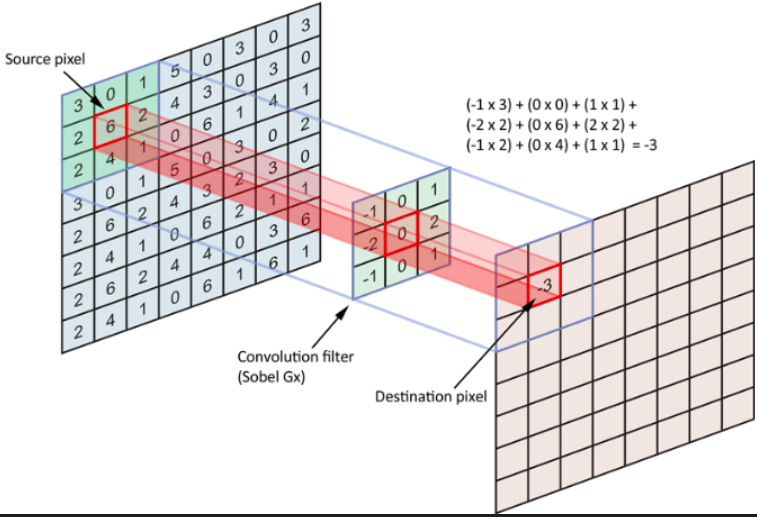


 <div style="background-color:yellow; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;">Training The Model </h1>
</div>


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

 <div style="background-color:white; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;">Analysis after Model Training</h1>
</div>


In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [ ]:
import numpy as np
predictions=np.argmax(model.predict(x_test),axis=1)
predictions=[p+1 if p>=9 else p for p in predictions]
predictions[:5]


In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

In [ ]:
cm = confusion_matrix(y,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
orrect = np.nonzero(predictions == y)[0]

Some of the Correctly Predicted Classes
 <div style="background-color:white; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;">Some of the Correctly Predicted Classes</h1>
</div>


In [ ]:

correct = np.where(predictions == y)[0]  
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1
plt.show()


<div style="background-color:#e6f2ff; padding:20px; border-radius:12px; border:1px solid #99ccff;">
  <h2 style="margin:0; color:#003366; text-align:center;">American Sign Language Recognition Using CNN — Notebook Summary</h2>
  <p style="margin-top:15px; font-size:18px; color:#1a1a1a; line-height:1.6; text-align:center;">
    This notebook demonstrates an end-to-end workflow for recognizing American Sign Language gestures.  
We preprocess the dataset, apply data augmentation, and train a Convolutional Neural Network for accurate classification.  
The model achieved an impressive accuracy of 0.9990, and the confusion matrix shows almost no misclassifications.  
All steps are optimized for robustness, reproducibility, and understanding how CNNs interpret hand gestures.  


  </p>
  <p style="margin-top:10px; font-size:16px; color:#004080; text-align:center; font-weight:bold;">
    All steps were optimized for stability, reproducibility, and leaderboard performance.
  </p>
  <h2 style="margin-top:20px; color:#003366; text-align:center;">Thank You!</h2>
</div>
